In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import tqdm

from msfm.utils import tfrecords, files, parameters, cross_statistics
from msfm.fiducial_pipeline import FiducialPipeline
from msfm.grid_pipeline import GridPipeline
from msfm.utils.input_output import read_yaml

2026-01-21 02:47:57.702615: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-21 02:47:57.702684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-21 02:47:57.704210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-21 02:47:57.715164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-21 02:47:58.866538: W tensorflow/compiler/tf2

In [3]:
with_lensing = True
with_clustering = True

# grid

In [4]:
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/debug/linear_bias/tfrecords/grid/DESy3_grid_dmb_0000.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/tfrecords/grid/DESy3_grid_dmb_0000.tfrecord"

tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/debug/linear_bias/tfrecords/grid/DESy3power_law_grid_dmb_0000.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/tfrecords/grid/DESy3per_bin_grid_dmb_0000.tfrecord"

# conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias_debug.yaml"
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml"
conf = files.load_config(conf)

params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]

In [5]:
grid_pipe = GridPipeline(
    conf=conf,
    params=params,
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_padding=True,
    apply_norm=False,
    return_maps=True,
)

data_vec_pix = grid_pipe.data_vec_pix
n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)
n_z = grid_pipe.n_z_metacal + grid_pipe.n_z_maglim
n_z_metacal = grid_pipe.n_z_metacal
n_noise = conf["analysis"]["grid"]["n_noise_per_example"]
# n_noise = 1

24-10-01 07:11:22     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-10-01 07:11:22     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


In [6]:
n_perms_per_cosmo = conf["analysis"]["grid"]["n_perms_per_cosmo"]
n_patches = conf["analysis"]["n_patches"]
n_signal = n_perms_per_cosmo * n_patches

batch_size = 1
n_batches = n_signal * n_noise // batch_size

In [7]:
grid_dset = grid_pipe.get_dset(
    tfr_pattern="/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/tfrecords/grid/DESy3_grid_dmb_0000.tfrecord",
    noise_indices=1,
    local_batch_size=1,
    n_readers=1,
    n_prefetch=0,
    is_eval=True,
)

i = 0
for dv, cl, cosmo, index in tqdm(grid_dset):
    i += 1
print(i)

24-10-01 07:11:24 grid_pipelin INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-10-01 07:11:24 grid_pipelin INF   drop_remainder is not set, using drop_remainder = False 
24-10-01 07:11:24 grid_pipelin INF   Including noise_indices = [0] 
24-10-01 07:11:24 grid_pipelin INF   Interleaving with n_readers = 1 
dict_keys(['cosmo', 'i_sobol', 'i_example', 'kg', 'dg', 'cl'])
24-10-01 07:11:25 grid_pipelin INF   Batching into 1 elements locally 
24-10-01 07:11:26 grid_pipelin WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbo

80it [00:05, 14.53it/s]

80


In [ ]:
grid_dset = grid_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    noise_indices=n_noise,
    local_batch_size=batch_size,
    n_readers=1,
    n_prefetch=0,
    is_eval=True,
)

i = 0
for dv, cl, cosmo, index in grid_dset:
    print(index[1])
    i += 1
    
print(i)

24-10-01 07:11:33 grid_pipelin INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-10-01 07:11:33 grid_pipelin INF   drop_remainder is not set, using drop_remainder = False 
24-10-01 07:11:33 grid_pipelin INF   Including noise_indices = [0, 1, 2, 3, 4] 


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: /pscratch/sd/a/athomsen/v11desy3/v10/debug/linear_bias/tfrecords/grid/DESy3power_law_grid_dmb_0000.tfrecord'

In [ ]:
# grid_dset = grid_pipe.get_dset(
#     tfr_pattern=tfr_pattern,
#     noise_indices=n_noise,
#     local_batch_size=batch_size,
#     n_readers=1,
#     n_prefetch=0,
#     is_eval=False,
# )

# for dv, cl, cosmo, index in tqdm(grid_dset.take(n_batches), total=n_batches):
#     print(index[1])

# cross maps

In [52]:
tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v16/default/tfrecords/grid/debug/DESy3_grid_dmb_0000.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v16/no_cross/tfrecords/grid/debug/DESy3_grid_dmb_0000.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v15/extended/tfrecords/grid/DESy3_grid_dmb_1873.tfrecord"

conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v16/default.yaml"
conf = files.load_config(conf)

params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bta", "bg1", "bg2", "bg3", "bg4"]

# with_lensing = True
# with_clustering = True
# with_cross = False

with_lensing = False
with_clustering = False
with_cross = True

In [53]:
grid_pipe = GridPipeline(
    conf=conf,
    params=params,
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_cross=with_cross,
    with_padding=True,
    apply_norm=False,
    return_maps=True,
    return_cls=False,
)


In [54]:
grid_dset = grid_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    noise_indices=1,
    local_batch_size=1,
    n_readers=1,
    n_prefetch=0,
    is_eval=True,
)

i = 0
for dv, cl, cosmo, index in tqdm(grid_dset):
# for x in tqdm(grid_dset):
    i += 1
print(i)
print(dv.shape)

26-01-21 03:10:51 grid_pipelin INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
26-01-21 03:10:51 grid_pipelin INF   drop_remainder is not set, using drop_remainder = False 
26-01-21 03:10:51 grid_pipelin INF   Including noise_indices = [0] 
26-01-21 03:10:51 grid_pipelin INF   Interleaving with n_readers = 1 
26-01-21 03:10:51 grid_pipelin INF   Batching into 1 elements locally 
26-01-21 03:10:51 grid_pipelin WAR   Tracing _augmentations 
26-01-21 03:10:51 grid_pipelin INF   Running on the data_vectors.keys() = dict_keys(['cosmo', 'i_sobol', 'i_example', 'xg', 'i_noise']) 
26-01-21 03:10:51 grid_pipelin INF   Successfully generated the grid validation set with element_spec (TensorSpec(shape=(None, 458752, None), dtype=tf.float32, name=None), NoneTensorSpec(), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape

5it [00:00,  6.56it/s]

5
(1, 458752, 16)


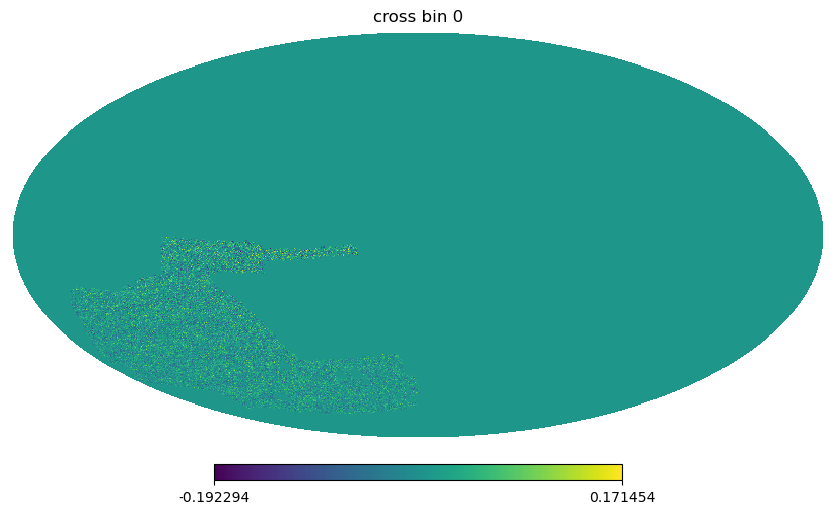

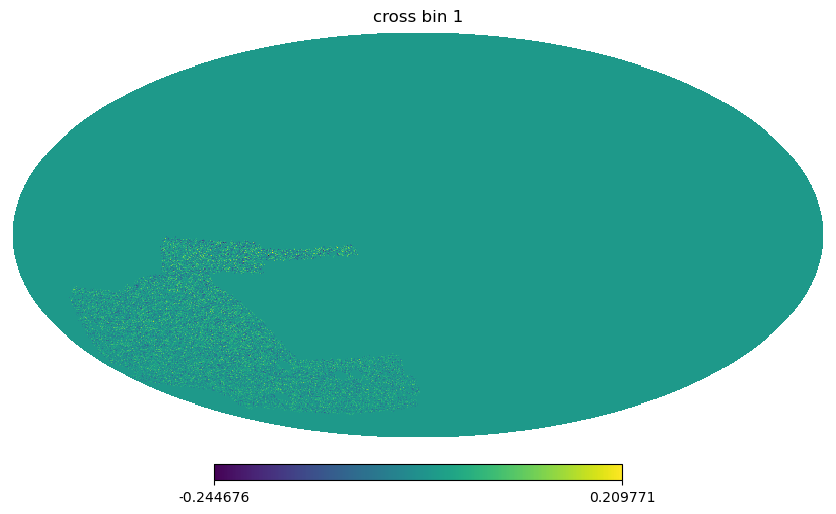

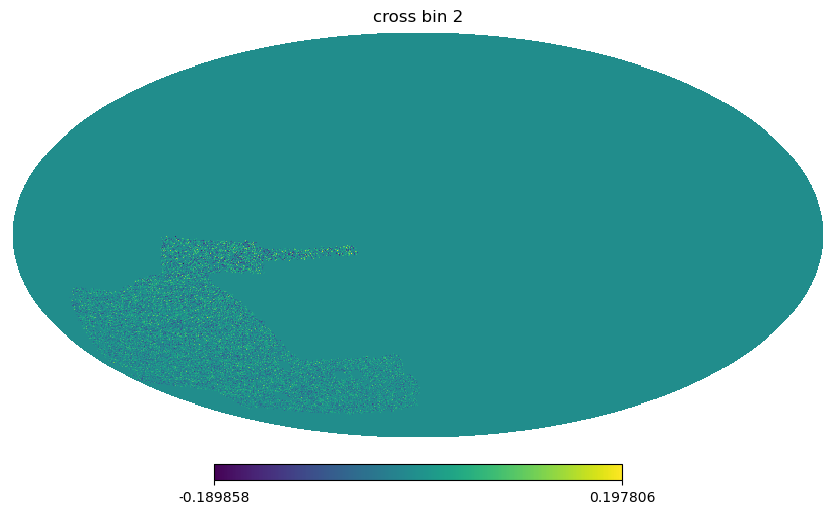

In [55]:
data_vec_pix = grid_pipe.data_vec_pix
n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)

for i in range(3):
    hp_map = np.zeros(n_pix)
    hp_map[data_vec_pix] = dv[0,:,i]

    hp.mollview(hp_map, nest=True, title=f"cross bin {i}")